### KNN

In [2]:
import numpy as np
import pandas as pd

!gdown 1ZdhRqYv-JizWV6DxO6C4R_k1kxPhmlF2
df=pd.read_csv('multiclass.csv')
df.head()

X=df[['Region',	'Fresh',	'Milk',	'Grocery',	'Frozen',	'Detergents_Paper',	'Delicassen'	]].copy()
y=df[['class']].copy()

Downloading...
From: https://drive.google.com/uc?id=1ZdhRqYv-JizWV6DxO6C4R_k1kxPhmlF2
To: /content/multiclass.csv
100% 14.6k/14.6k [00:00<00:00, 37.0MB/s]


In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=0.25, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val,test_size=0.25, random_state=42)

In [4]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(247, 7) (247, 1)
(83, 7) (83, 1)
(110, 7) (110, 1)


In [6]:
# Apply SMOTE
from imblearn.over_sampling import SMOTE

# Create an instance of SMOTE
smt = SMOTE()

X_sm, y_sm = smt.fit_resample(X_train, y_train)

y_sm.value_counts()

class
1        99
2        99
3        99
Name: count, dtype: int64

In [7]:
# Standardization

from sklearn.preprocessing import StandardScaler

st =  StandardScaler()

X_sm = st.fit_transform(X_sm.values)
X_val_scaled = st.transform(X_val.values)
X_test_scaled = st.transform(X_test.values)

y_sm = y_sm.values[:,0]
y_val = y_val.values[:,0]
y_test = y_test.values[:,0]

In [8]:
# Apply Manual KNN
# This 50th value is our xq data point
X_val_scaled[50]

array([ 0.70254634, -0.60630384, -0.44940254, -0.65869229, -0.294133  ,
       -0.50247148, -0.2725712 ])

In [10]:
dist = np.sqrt(np.sum((X_val_scaled[50]-X_sm)**2,axis=1) )

print(dist.shape)
#(297,)
# Storing distance and Class labels together
distances = [(dist[i],y_sm[i]) for i in range(len(dist)) ]

# sort the distances
distances = sorted(distances)

# Nearest/First K points
distances = distances[:5]

distances = np.array(distances)

classes_counts = np.unique(distances[:,1],return_counts=True)

index = classes_counts[1].argmax()
pred = classes_counts[0][index]

print('kNN prediction:',pred)
#KNN prediction: 3.0

(297,)
kNN prediction: 3.0


In [11]:
print('Neighbors[(distance),(Label)]:',distances)

Neighbors[(distance),(Label)]: [[0.20112006 3.        ]
 [0.21035073 3.        ]
 [0.23110117 3.        ]
 [0.28616566 3.        ]
 [0.29849215 3.        ]]


In [12]:
# Formulating into one function
def knn(X,Y,queryPoint,k):
    """Predict the class label for the query point"""
    # Euclidean Distance
    dist = np.sqrt(np.sum((queryPoint-X)**2,axis=1) )

    # Storing distance and Class labels together
    distances = [(dist[i],Y[i]) for i in range(len(dist)) ]
    # sort the distances
    distances = sorted(distances)
    # Nearest/First K points
    distances = distances[:k]

    distances = np.array(distances)

    classes_counts = np.unique(distances[:,1],return_counts=True)

    index = classes_counts[1].argmax()
    pred = classes_counts[0][index]

    return int(pred),distances

In [13]:
pred,neighbors = knn(X_sm, y_sm, X_val_scaled[50],5)

print(f'k nearest neighbors with the distance and class label :{neighbors}')

print(f'The predicted class label: {pred}')

k nearest neighbors with the distance and class label :[[0.20112006 3.        ]
 [0.21035073 3.        ]
 [0.23110117 3.        ]
 [0.28616566 3.        ]
 [0.29849215 3.        ]]
The predicted class label: 3


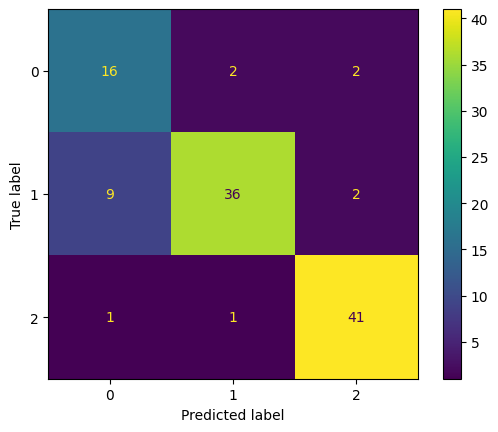

In [14]:
# To compare true and predicted label of data points
from sklearn.metrics import confusion_matrix

y_pred = []

for i in range(X_test_scaled.shape[0]):
    output,_ = knn(X_sm, y_sm, X_test_scaled[i],5)
    y_pred.append(output)




cm = confusion_matrix(y_test,y_pred)
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(cm).plot()

In [15]:
# score card
from sklearn.metrics import classification_report

print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           1       0.80      0.62      0.70        26
           2       0.77      0.92      0.84        39
           3       0.95      0.91      0.93        45

    accuracy                           0.85       110
   macro avg       0.84      0.82      0.82       110
weighted avg       0.85      0.85      0.84       110



In [16]:
# Apply Library wise KNN
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Fit the data
knn = KNeighborsClassifier(n_neighbors=5,metric='euclidean')

knn.fit(X_sm, y_sm)

KNeighborsClassifier(metric='euclidean')

In [17]:
from sklearn.metrics import classification_report

y_pred = knn.predict(X_val_scaled)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           1       0.76      0.93      0.84        14
           2       1.00      0.89      0.94        38
           3       0.94      0.97      0.95        31

    accuracy                           0.93        83
   macro avg       0.90      0.93      0.91        83
weighted avg       0.94      0.93      0.93        83



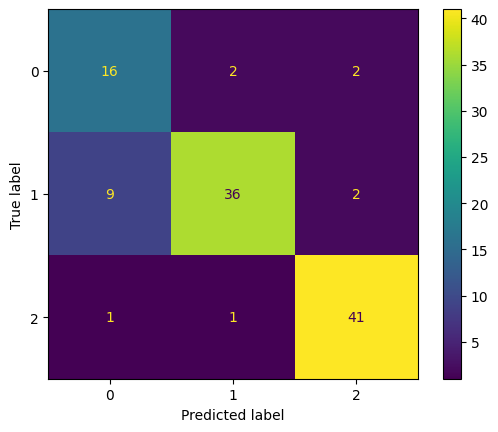

In [18]:
y_pred = knn.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm).plot()

Text(0, 0.5, 'Accuracy')

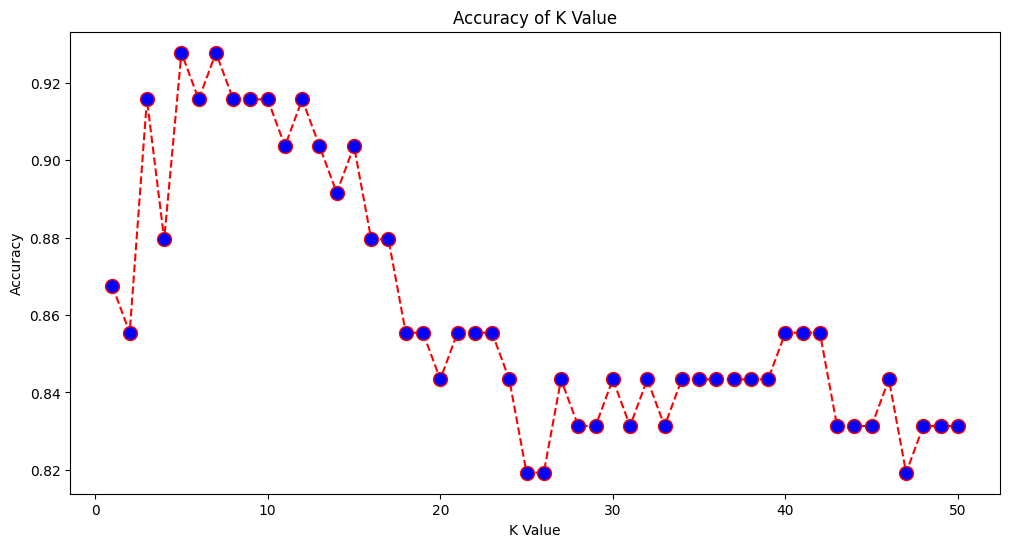

In [19]:
# Tunning of Hyperparameter
Acc = []

# Calculating error for K values between 1 and 50
# Note: 51 is not included in the loop
for i in range(1, 51):
    knn = KNeighborsClassifier(n_neighbors=i,metric='euclidean')
    knn.fit(X_sm, y_sm)

    Acc.append(knn.score(X_val_scaled,y_val))

#Vizualize the k-value
plt.figure(figsize=(12, 6))
plt.plot(range(1, 51), Acc, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Accuracy of K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')

In [21]:
# How to impute data/ by creating the Dummy data
!gdown 1vDIXh1yJxLpmgdh3gZGM6WX0u3GCPuIS

Downloading...
From: https://drive.google.com/uc?id=1vDIXh1yJxLpmgdh3gZGM6WX0u3GCPuIS
To: /content/knn_imputation.csv
100% 12.9k/12.9k [00:00<00:00, 32.3MB/s]


In [22]:
df_imp = pd.read_csv('knn_imputation.csv')
df_imp.drop(['Unnamed: 0'],axis=1,inplace=True)
df_imp.head()

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,3.0,12669.0,9656.0,7561.0,214.0,2674.0,1338.0
1,3.0,7057.0,9810.0,9568.0,1762.0,3293.0,1776.0
2,3.0,6353.0,8808.0,NaN,2405.0,3516.0,7844.0
3,3.0,13265.0,1196.0,4221.0,6404.0,507.0,1788.0
4,3.0,22615.0,5410.0,7198.0,3915.0,1777.0,5185.0


In [23]:
df_imp.isna().sum()

Region               8
Fresh               13
Milk                15
Grocery              9
Frozen               8
Detergents_Paper    10
Delicassen          11
dtype: int64

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: StandardScaler for feature scaling
    ('imputer', KNNImputer(n_neighbors=5))  # Step 2: KNNImputer for missing value imputation
])

# Fit and transform the data using the pipeline
X_transformed = pipeline.fit_transform(df_imp)

# Creating dataframe
X_transformed = pd.DataFrame(X_transformed,columns=df_imp.columns)

X_transformed.isna().sum()

Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

DECISION TREE

In [1]:
# Open lec 2nd of Decision tree for better code snipets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io

In [2]:
!gdown 16KtxSt_QEGQvfluEaMls5cCHPwhRXgCk

Downloading...
From: https://drive.google.com/uc?id=16KtxSt_QEGQvfluEaMls5cCHPwhRXgCk
To: /content/HR-Employee-Attrition.csv
100% 228k/228k [00:00<00:00, 78.3MB/s]


In [3]:
ds= pd.read_csv("HR-Employee-Attrition.csv")
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [4]:
ds.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [8]:
!gdown 19L3rYatfhbBL1r5MHrv-p_oM2wlvrhqk
!gdown 1OHLKJwA3qZopKPvlKoRldM6BvA1A4dYF
!gdown 1N7O_fWCTJLu8SIa_paKcDEzllgpMk8sK
!gdown 12Bh2AN8LcZAlg20ehpQrEWccUDaSdsOG

Downloading...
From: https://drive.google.com/uc?id=19L3rYatfhbBL1r5MHrv-p_oM2wlvrhqk
To: /content/preprocessed_X_sm.pickle
100% 534k/534k [00:00<00:00, 27.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OHLKJwA3qZopKPvlKoRldM6BvA1A4dYF
To: /content/X_test.pickle
100% 111k/111k [00:00<00:00, 59.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1N7O_fWCTJLu8SIa_paKcDEzllgpMk8sK
To: /content/y_sm.pickle
100% 15.4k/15.4k [00:00<00:00, 23.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=12Bh2AN8LcZAlg20ehpQrEWccUDaSdsOG
To: /content/y_test.pickle
100% 9.49k/9.49k [00:00<00:00, 22.9MB/s]


In [13]:
"""import pickle
# Load data (deserialize)
with open('preprocessed_X_sm.pickle', 'rb') as handle:
    X_train = pickle.load(handle)

with open('X_test.pickle', 'rb') as handle:
    X_test = pickle.load(handle)

with open('y_sm.pickle', 'rb') as handle:
    y_train = pickle.load(handle)

with open('y_test.pickle', 'rb') as handle:
    y_test = pickle.load(handle)"""

"import pickle\n# Load data (deserialize)\nwith open('preprocessed_X_sm.pickle', 'rb') as handle:\n    X_train = pickle.load(handle)\n\nwith open('X_test.pickle', 'rb') as handle:\n    X_test = pickle.load(handle)\n\nwith open('y_sm.pickle', 'rb') as handle:\n    y_train = pickle.load(handle)\n\nwith open('y_test.pickle', 'rb') as handle:\n    y_test = pickle.load(handle)"

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_validate, cross_val_score

kfold = KFold(n_splits=10)

depths = [3,4,5,67,9,11,13,15]

for depth in depths:
    tree_clf = DecisionTreeClassifier(random_state=7, max_depth=depth)

    cv_acc_results = cross_validate(tree_clf, X_train, y_train, cv = kfold, scoring = 'accuracy', return_train_score = True)

    print(f"K-Fold for depth:{depth} Accuracy Mean: Train: {cv_acc_results['train_score'].mean()*100} Validation: {cv_acc_results['test_score'].mean()*100}")
    print(f"K-Fold for depth: {depth} Accuracy Std: Train: {cv_acc_results['train_score'].std()*100} Validation: {cv_acc_results['test_score'].std()*100}")
    print('***************')

In [ ]:
# Traning with best parameters
tree_clf = DecisionTreeClassifier(random_state=7, max_depth=4)
tree_clf=tree_clf.fit(X_train, y_train)
pred = tree_clf.predict(X_test)

In [ ]:
# Visualisation
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot

features = list(X_train.columns)

# Ensure the target variable 'Attrition' is not there in the feature list

dot_data = StringIO()
export_graphviz(tree_clf, out_file=dot_data, feature_names=features, filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

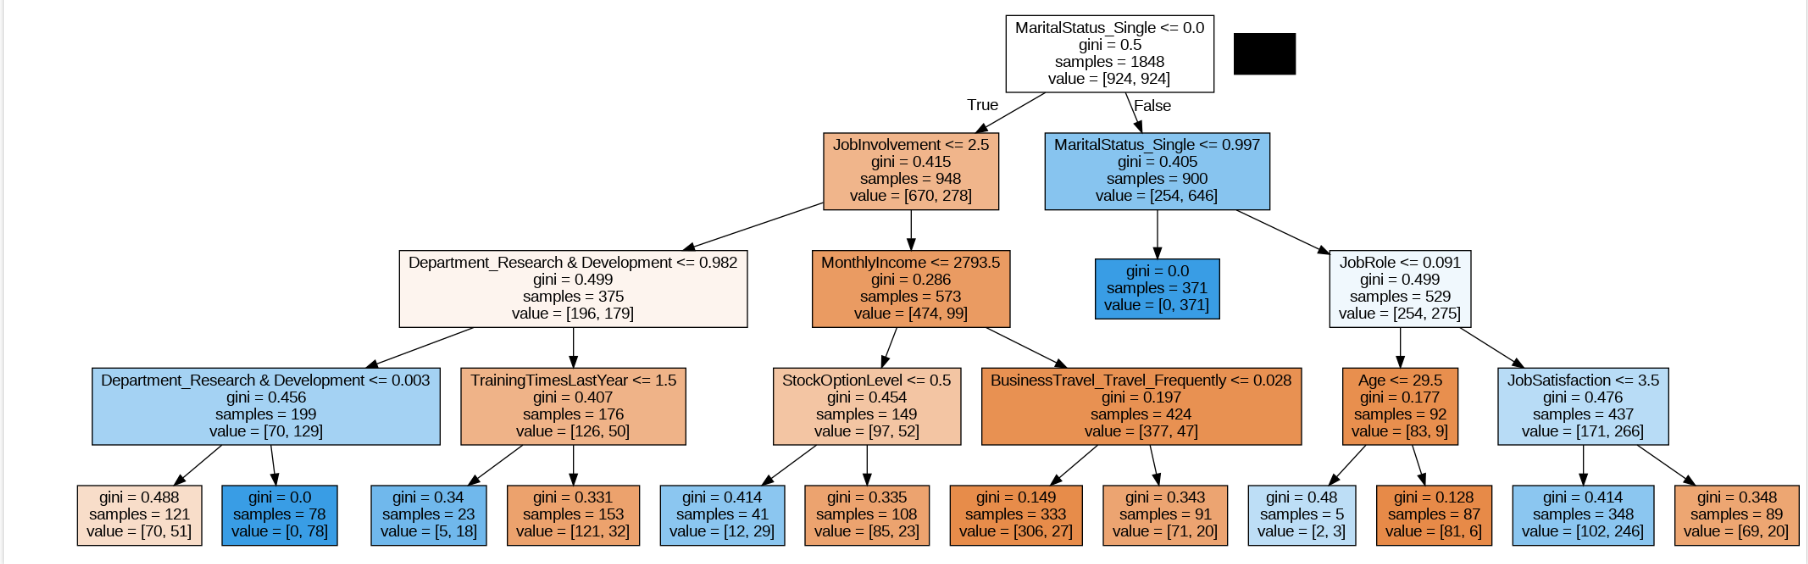

In [ ]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cnf_matrix = confusion_matrix(y_test, pred)
fig, ax = plt.subplots()

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
importances = tree_clf.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X_train.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances

plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature Importance") # Create plot title
plt.bar(range(X_train.shape[1]), importances[indices]) # Add bars
plt.xticks(range(X_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

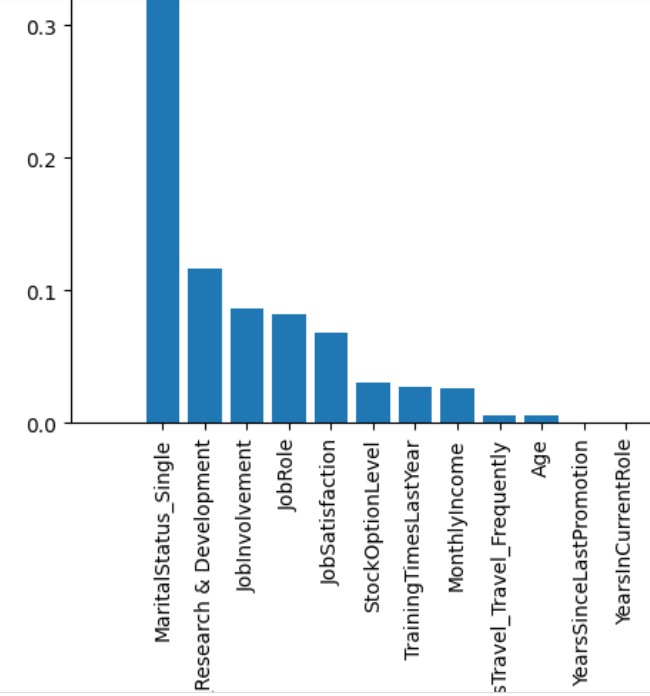

In [ ]:
df_param_coeff = pd.DataFrame(columns=['Feature', 'Coefficient'])
for i in range(len(list(X_train.columns))):
    feat = X_train.columns[i]
    coeff = importances[i]
    df_param_coeff.loc[i] = (feat, coeff)
df_param_coeff.sort_values(by='Coefficient', ascending=False, inplace=True)
df_param_coeff = df_param_coeff.reset_index(drop=True)
df_param_coeff.head(10)

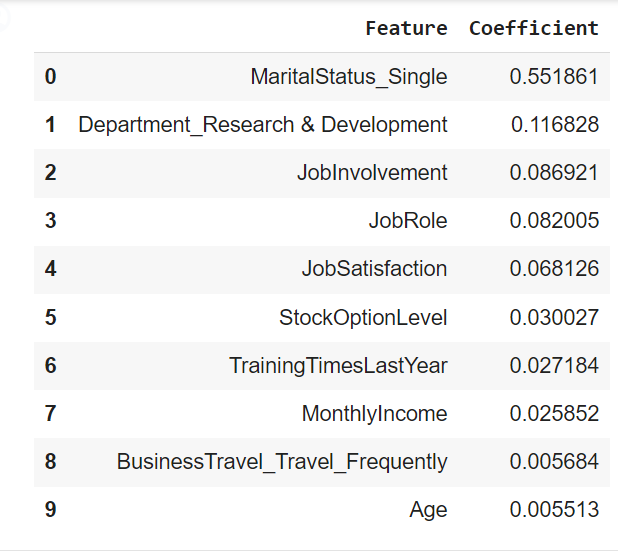

## Random Forest

In [1]:
import pandas as pd
import numpy as np

In [2]:
!gdown 16KtxSt_QEGQvfluEaMls5cCHPwhRXgCk
!gdown 19L3rYatfhbBL1r5MHrv-p_oM2wlvrhqk
!gdown 1OHLKJwA3qZopKPvlKoRldM6BvA1A4dYF
!gdown 1N7O_fWCTJLu8SIa_paKcDEzllgpMk8sK
!gdown 12Bh2AN8LcZAlg20ehpQrEWccUDaSdsOG

Downloading...
From: https://drive.google.com/uc?id=16KtxSt_QEGQvfluEaMls5cCHPwhRXgCk
To: /content/HR-Employee-Attrition.csv
100% 228k/228k [00:00<00:00, 6.21MB/s]
Downloading...
From: https://drive.google.com/uc?id=19L3rYatfhbBL1r5MHrv-p_oM2wlvrhqk
To: /content/preprocessed_X_sm.pickle
100% 534k/534k [00:00<00:00, 32.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OHLKJwA3qZopKPvlKoRldM6BvA1A4dYF
To: /content/X_test.pickle
100% 111k/111k [00:00<00:00, 65.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1N7O_fWCTJLu8SIa_paKcDEzllgpMk8sK
To: /content/y_sm.pickle
100% 15.4k/15.4k [00:00<00:00, 28.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=12Bh2AN8LcZAlg20ehpQrEWccUDaSdsOG
To: /content/y_test.pickle
100% 9.49k/9.49k [00:00<00:00, 19.7MB/s]


In [4]:
"""import pickle
# Load data (deserialize)
with open('preprocessed_X_sm.pickle', 'rb') as handle:
    X_train = pickle.load(handle)

with open('X_test.pickle', 'rb') as handle:
    X_test = pickle.load(handle)

with open('y_sm.pickle', 'rb') as handle:
    y_train = pickle.load(handle)

with open('y_test.pickle', 'rb') as handle:
    y_test = pickle.load(handle)"""

"import pickle\n# Load data (deserialize)\nwith open('preprocessed_X_sm.pickle', 'rb') as handle:\n    X_train = pickle.load(handle)\n\nwith open('X_test.pickle', 'rb') as handle:\n    X_test = pickle.load(handle)\n\nwith open('y_sm.pickle', 'rb') as handle:\n    y_train = pickle.load(handle)\n\nwith open('y_test.pickle', 'rb') as handle:\n    y_test = pickle.load(handle)"

In [ ]:
# Value of accuracy by DT only
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=7, max_depth=4)
tree_clf.fit(X_train, y_train)

In [ ]:
print("Train accuracy: {:.2f}".format(tree_clf.score(X_train, y_train)*100))
print("Test accuracy: {:.2f}".format(tree_clf.score(X_test, y_test)*100))
# Train accuracy: 83.77
# Test accuracy: 78.80

In [ ]:
# Load data (deserialize)

with open('preprocessed_X_sm.pickle', 'rb') as handle:
    X = pickle.load(handle)

with open('y_sm.pickle', 'rb') as handle:
    y = pickle.load(handle)

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=7, max_depth=4, n_estimators=100) #value of k is 100

In [ ]:
from sklearn.model_selection import KFold, cross_validate

kfold = KFold(n_splits=10)
cv_acc_results = cross_validate(rf_clf, X, y, cv=kfold, scoring='accuracy', return_train_score=True)

print(f"K-Fold Accuracy Mean: \n Train: {cv_acc_results['train_score'].mean()*100:.2f} \n Validation: {cv_acc_results['test_score'].mean()*100:.2f}")
print(f"K-Fold Accuracy Std: \n Train: {cv_acc_results['train_score'].std()*100:.2f}, \n Validation: {cv_acc_results['test_score'].std()*100:.2f}")

# Train accuracy: 88.41
# Test accuracy: 84.26 (accuracy has been increased)

In [6]:
# Hyperparameter tunning by using Grid search and Random search
# Defining parameters -

params = {
          'n_estimators' : [100,200,300,400],
          'max_depth' : [3,5,10],
          'criterion' : ['gini', 'entropy'],
          'bootstrap' : [True, False],
          'max_features' : [8,9,10]
         }

In [9]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator = RandomForestClassifier(),
                    param_grid = params,
                    scoring = 'accuracy',
                    cv = 3,
                    n_jobs=-1
                    )

In [ ]:
grid.fit(X, y)

print("Best params: ", grid.best_params_)
print("Best score: ", grid.best_score_)

# Best params:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 8, 'n_estimators': 400}
# Best score:  0.9004329004329005

In [ ]:
# Change the hyper perameter as per Grid result
clf2 = RandomForestClassifier(random_state=7, bootstrap=False, criterion='gini',
                              max_depth=10, max_features=8, n_estimators=200)

kfold = KFold(n_splits=10)
cv_acc_results = cross_validate(clf2, X, y, cv=kfold, scoring='accuracy', return_train_score=True)

print(f"K-Fold Accuracy Mean: \n Train: {cv_acc_results['train_score'].mean()*100:.3f} \n Validation: {cv_acc_results['test_score'].mean()*100:.3f}")
print(f"K-Fold Accuracy Std: \n Train: {cv_acc_results['train_score'].std()*100:.3f}, \n Validation: {cv_acc_results['test_score'].std()*100:.3f}")

"""K-Fold Accuracy Mean:
 Train: 99.657
 Validation: 91.999
K-Fold Accuracy Std:
 Train: 0.085,
 Validation: 6.801"""

In [ ]:
# Defining parameters - By Random search

from scipy.stats import uniform

params = {'ccp_alpha': uniform(loc=0, scale=0.4)}
# sample from uniform dist between 0 to 0.4

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

random = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=7, bootstrap=False, criterion='gini',
                                                               max_depth=10, max_features=8, n_estimators=200),
                            param_distributions = params,
                            scoring = 'accuracy',
                            cv = 3,
                            n_iter=15,
                            n_jobs=-1
                            )

In [ ]:
random.fit(X, y)

print("Best param: ", random.best_params_)
print("Best score: ", random.best_score_)

# Best param:  {'ccp_alpha': 0.005823753282778954}
# Best score:  0.850108225108225

## Boosting and GBDT

In [3]:
import pandas as pd
import numpy as np

!gdown 19L3rYatfhbBL1r5MHrv-p_oM2wlvrhqk
!gdown 1OHLKJwA3qZopKPvlKoRldM6BvA1A4dYF
!gdown 1N7O_fWCTJLu8SIa_paKcDEzllgpMk8sK
!gdown 12Bh2AN8LcZAlg20ehpQrEWccUDaSdsOG

"""import pickle
# Load data (deserialize)
with open('preprocessed_X_sm.pickle', 'rb') as handle:
    X_train = pickle.load(handle)

with open('X_test.pickle', 'rb') as handle:
    X_test = pickle.load(handle)

with open('y_sm.pickle', 'rb') as handle:
    y_train = pickle.load(handle)

with open('y_test.pickle', 'rb') as handle:
    y_test = pickle.load(handle)"""

from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=150, max_depth=2, loss = 'log_loss')

gbc.fit(X_train, y_train)

gbc.score(X_test, y_test)
# 0.8804
gbc.score(X_train, y_train)
# 0.9481

Downloading...
From: https://drive.google.com/uc?id=19L3rYatfhbBL1r5MHrv-p_oM2wlvrhqk
To: /content/preprocessed_X_sm.pickle
100% 534k/534k [00:00<00:00, 57.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OHLKJwA3qZopKPvlKoRldM6BvA1A4dYF
To: /content/X_test.pickle
100% 111k/111k [00:00<00:00, 61.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1N7O_fWCTJLu8SIa_paKcDEzllgpMk8sK
To: /content/y_sm.pickle
100% 15.4k/15.4k [00:00<00:00, 29.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=12Bh2AN8LcZAlg20ehpQrEWccUDaSdsOG
To: /content/y_test.pickle
100% 9.49k/9.49k [00:00<00:00, 26.8MB/s]


In [4]:
# Preprocessed data
# How preprocessing occurs? (https://colab.research.google.com/drive/1jRl6U-gGxTvT1FHGzMW-5BDAhQ6ON6om?usp=sharing)
import pickle

!gdown 171Yoe_GSapyrmOnD9oBzHWNOD_OnQs0F
!gdown 1hnIlTPW3AMeB69EbeaXCRIrpMVT1Vwmc
!gdown 1nZtB_RtxMg_MgoRczb8UWQX-AEK_l3qE
!gdown 1zLDUErwKdmF-RacOyHEuI_z_46LssQtP


with open('X_train.pickle', 'rb') as handle:
    X_train = pickle.load(handle)

with open('X_test.pickle', 'rb') as handle:
    X_test = pickle.load(handle)

with open('Y_train.pickle', 'rb') as handle:
    y_train = pickle.load(handle)

with open('Y_test.pickle', 'rb') as handle:
    y_test = pickle.load(handle)

Downloading...
From: https://drive.google.com/uc?id=171Yoe_GSapyrmOnD9oBzHWNOD_OnQs0F
To: /content/Y_test.pickle
100% 31.7k/31.7k [00:00<00:00, 33.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hnIlTPW3AMeB69EbeaXCRIrpMVT1Vwmc
To: /content/X_test.pickle
100% 253k/253k [00:00<00:00, 33.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nZtB_RtxMg_MgoRczb8UWQX-AEK_l3qE
To: /content/Y_train.pickle
100% 126k/126k [00:00<00:00, 64.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zLDUErwKdmF-RacOyHEuI_z_46LssQtP
To: /content/X_train.pickle
100% 1.01M/1.01M [00:00<00:00, 76.6MB/s]


In [5]:
# Firstly by Decision Tree
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn import tree
from sklearn.model_selection import GridSearchCV

params = {
    "max_depth" : [3, 5, 7, 10, 15],
    "max_leaf_nodes" : [20, 40, 60]
}

model1 = DTC()
clf = GridSearchCV(model1, params, scoring = "accuracy", cv=5)

clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7, 10, 15],
                         'max_leaf_nodes': [20, 40, 60]},
             scoring='accuracy')

In [6]:
res = clf.cv_results_

for i in range(len(res["params"])):
  print(f"Parameters:{res['params'][i]} Mean_score: {res['mean_test_score'][i]} Rank: {res['rank_test_score'][i]}")

Parameters:{'max_depth': 3, 'max_leaf_nodes': 20} Mean_score: 0.34202167978841097 Rank: 15
Parameters:{'max_depth': 3, 'max_leaf_nodes': 40} Mean_score: 0.34208509132931136 Rank: 13
Parameters:{'max_depth': 3, 'max_leaf_nodes': 60} Mean_score: 0.34208509132931136 Rank: 13
Parameters:{'max_depth': 5, 'max_leaf_nodes': 20} Mean_score: 0.44647305733525516 Rank: 12
Parameters:{'max_depth': 5, 'max_leaf_nodes': 40} Mean_score: 0.4465998401940679 Rank: 11
Parameters:{'max_depth': 5, 'max_leaf_nodes': 60} Mean_score: 0.44666327184646243 Rank: 10
Parameters:{'max_depth': 7, 'max_leaf_nodes': 20} Mean_score: 0.632800378739657 Rank: 9
Parameters:{'max_depth': 7, 'max_leaf_nodes': 40} Mean_score: 0.6351470079828554 Rank: 8
Parameters:{'max_depth': 7, 'max_leaf_nodes': 60} Mean_score: 0.6351470280943495 Rank: 7
Parameters:{'max_depth': 10, 'max_leaf_nodes': 20} Mean_score: 0.6976794754761447 Rank: 5
Parameters:{'max_depth': 10, 'max_leaf_nodes': 40} Mean_score: 0.773402086487067 Rank: 4
Parameters

In [7]:
print(clf.best_estimator_)

DecisionTreeClassifier(max_depth=15, max_leaf_nodes=60)


In [11]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, max_leaf_nodes=60)

In [12]:
# Train score
clf.score(X_train, y_train)

0.8223617453069508

In [13]:
# Test score
clf.score(X_test, y_test)

# nominal Overfitting observe but this score can be improved by using the RF/GBDT

0.8125792543748415

In [15]:
# Secondly by RF
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
import datetime as dt

params = {
    "n_estimators": [10,25,50,100,150,200],
    "max_depth" : [3, 5, 10, 15, 20],
    "max_leaf_nodes" : [20, 40, 80]
}

rfc = RFC(n_jobs = -1)
clf = RandomizedSearchCV(rfc, params, scoring = "accuracy", cv=3, n_jobs = -1, verbose = 1)

start = dt.datetime.now()
clf.fit(X_train, y_train)
end = dt.datetime.now()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [16]:
res = clf.cv_results_

for i in range(len(res["params"])):
  print(f"Parameters:{res['params'][i]} Mean_score: {res['mean_test_score'][i]} Rank: {res['rank_test_score'][i]}")

Parameters:{'n_estimators': 200, 'max_leaf_nodes': 80, 'max_depth': 20} Mean_score: 0.8924403855910704 Rank: 1
Parameters:{'n_estimators': 100, 'max_leaf_nodes': 80, 'max_depth': 10} Mean_score: 0.8865423642820902 Rank: 2
Parameters:{'n_estimators': 100, 'max_leaf_nodes': 40, 'max_depth': 10} Mean_score: 0.8519152714358195 Rank: 5
Parameters:{'n_estimators': 100, 'max_leaf_nodes': 20, 'max_depth': 15} Mean_score: 0.7969304921359717 Rank: 9
Parameters:{'n_estimators': 200, 'max_leaf_nodes': 40, 'max_depth': 20} Mean_score: 0.8569254185692542 Rank: 4
Parameters:{'n_estimators': 100, 'max_leaf_nodes': 20, 'max_depth': 10} Mean_score: 0.8037163876204972 Rank: 8
Parameters:{'n_estimators': 10, 'max_leaf_nodes': 40, 'max_depth': 10} Mean_score: 0.8298452562151192 Rank: 7
Parameters:{'n_estimators': 100, 'max_leaf_nodes': 40, 'max_depth': 15} Mean_score: 0.8516615930999493 Rank: 6
Parameters:{'n_estimators': 50, 'max_leaf_nodes': 80, 'max_depth': 3} Mean_score: 0.6527143581938103 Rank: 10
Par

In [17]:
print(clf.best_estimator_)

RandomForestClassifier(max_depth=20, max_leaf_nodes=80, n_estimators=200,
                       n_jobs=-1)


In [18]:
rf = clf.best_estimator_

rf.fit(X_train, y_train)

print("Model acc",rf.score(X_test, y_test))
# Here score of RF is better then DT model.

Model acc 0.8929748922140502


In [19]:
# BY using the GBDT
params = {
    "n_estimators": [50,100,150,200],
    "max_depth" : [3, 4, 5, 7],
    "max_leaf_nodes" : [20, 40, 80],
    "learning_rate": [0.1, 0.2, 0.3]
}

In [20]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.model_selection import RandomizedSearchCV
import datetime as dt


gbc = GBC()
clf = RandomizedSearchCV(gbc, params, scoring = "accuracy", cv=3, n_jobs = -1, verbose = 1)

start = dt.datetime.now()

clf.fit(X_train, y_train)

end = dt.datetime.now()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [21]:
res = clf.cv_results_

for i in range(len(res["params"])):
  print(f"Parameters:{res['params'][i]} Mean_score: {res['mean_test_score'][i]} Rank: {res['rank_test_score'][i]}")

Parameters:{'n_estimators': 50, 'max_leaf_nodes': 20, 'max_depth': 5, 'learning_rate': 0.1} Mean_score: 0.9330923389142568 Rank: 8
Parameters:{'n_estimators': 150, 'max_leaf_nodes': 40, 'max_depth': 4, 'learning_rate': 0.1} Mean_score: 0.9437468290208016 Rank: 5
Parameters:{'n_estimators': 50, 'max_leaf_nodes': 20, 'max_depth': 5, 'learning_rate': 0.3} Mean_score: 0.9341704718417047 Rank: 7
Parameters:{'n_estimators': 50, 'max_leaf_nodes': 20, 'max_depth': 4, 'learning_rate': 0.3} Mean_score: 0.9323313039066464 Rank: 9
Parameters:{'n_estimators': 150, 'max_leaf_nodes': 40, 'max_depth': 7, 'learning_rate': 0.1} Mean_score: 0.9556062912227296 Rank: 1
Parameters:{'n_estimators': 50, 'max_leaf_nodes': 80, 'max_depth': 3, 'learning_rate': 0.2} Mean_score: 0.9214865550481989 Rank: 10
Parameters:{'n_estimators': 150, 'max_leaf_nodes': 80, 'max_depth': 3, 'learning_rate': 0.3} Mean_score: 0.935882800608828 Rank: 6
Parameters:{'n_estimators': 200, 'max_leaf_nodes': 40, 'max_depth': 5, 'learning

In [22]:
print(f"Time taken for fits : {end - start}")

Time taken for fits : 0:58:16.302515


In [23]:
print(clf.best_estimator_)

GradientBoostingClassifier(max_depth=7, max_leaf_nodes=40, n_estimators=150)


In [24]:
gbc = clf.best_estimator_

gbc.fit(X_train, y_train)

print("Model acc",gbc.score(X_test, y_test))

# Accuracy is the best but it take almost 30+ min to compute all the possible ways.

Model acc 0.9700735480598529


##Naive Bayes

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import warnings # to ignore the warning in outpluts
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
!gdown 1d4VFxFxPqBpKoUuH51PQ8PYrFBmPCnH8

Downloading...
From: https://drive.google.com/uc?id=1d4VFxFxPqBpKoUuH51PQ8PYrFBmPCnH8
To: /content/spam_clean.csv
100% 484k/484k [00:00<00:00, 55.8MB/s]


In [ ]:
df= pd.read_csv("spam_clean.csv", encoding="latin-1")
df.head()

,type,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<Axes: xlabel='type', ylabel='count'>

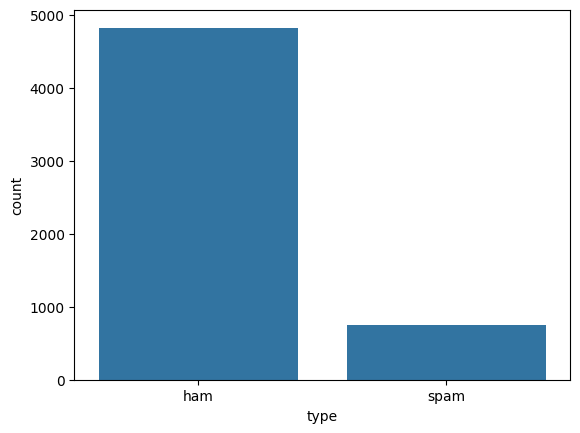

In [ ]:
sns.countplot(data= df, x= 'type')

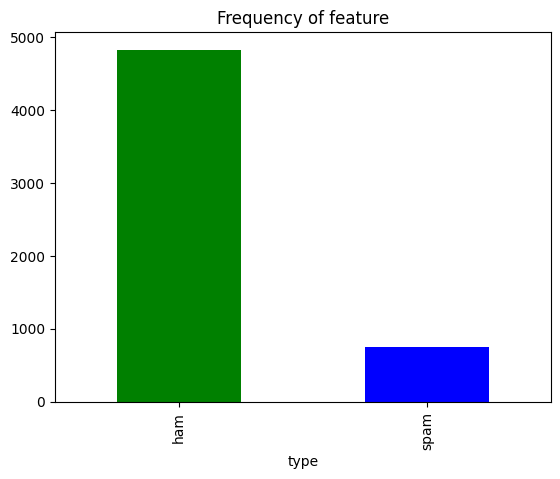

In [ ]:
df['type'].value_counts().plot(kind="bar", color=["green","blue"])
plt.title("Frequency of feature")
plt.show() # unbalanced data

Processing of Data
1. Tokenization- words ko alag alag karna
2. Lower casing
3. Removing Punctuations
4. Stop words removal- conjunctions[is, am,are, he, she, etc.]

In [ ]:
import re, nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

def clean_tokenized_sentence(s):
  cleaned_s= "" # create empty string to store cleaned sentence
  words= nltk.word_tokenize(s)
  for word in words:
    c_word= word.lower() # convert to lower case
    c_word= re.sub(r'[^\w\s]','',c_word) # remove Punctuations
    if c_word != '' and c_word not in stopwords.words("english"):
      cleaned_s= cleaned_s + " " + c_word # append processed word to new list
  return (cleaned_s.strip())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# 'apply' is applied here
df["cleaned_message"]= df["message"].apply(clean_tokenized_sentence)
df.head(10)

,type,message,cleaned_message
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah nt think goes usf lives around though
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darling 3 week word back like fun ...
6,ham,Even my brother is not like to speak with me. ...,even brother like speak treat like aids patent
7,ham,As per your request 'Melle Melle (Oru Minnamin...,per request melle melle oru minnaminunginte nu...
8,spam,WINNER!! As a valued network customer you have...,winner valued network customer selected receiv...
9,spam,Had your mobile 11 months or more? U R entitle...,mobile 11 months u r entitled update latest co...


In [ ]:
df.shape

(5572, 3)

In [ ]:
# 'counter' is used to count the frequency of the each word
# separate the ham and spam
Ham= df[df["type"]=="ham"]
Ham

,type,message,cleaned_message
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah nt think goes usf lives around though
6,ham,Even my brother is not like to speak with me. ...,even brother like speak treat like aids patent
...,...,...,...
5565,ham,Huh y lei...,huh lei
5568,ham,Will Ì_ b going to esplanade fr home?,ì_ b going esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",pity mood suggestions
5570,ham,The guy did some bitching but I acted like i'd...,guy bitching acted like interested buying some...


In [ ]:
spam= df[df['type'] == 'spam']
spam

,type,message,cleaned_message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darling 3 week word back like fun ...
8,spam,WINNER!! As a valued network customer you have...,winner valued network customer selected receiv...
9,spam,Had your mobile 11 months or more? U R entitle...,mobile 11 months u r entitled update latest co...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",six chances win cash 100 20000 pounds txt csh1...
...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,want explicit sex 30 secs ring 02073162414 cos...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,asked 3mobile 0870 chatlines inclu free mins i...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,contract mobile 11 mnths latest motorola nokia...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,reminder o2 get 250 pounds free call credit de...


In [ ]:
Ham= Ham["cleaned_message"]
Ham= " ".join(Ham) # we joined the cleaned_messages from rows of complete dataset in one line
Ham

'go jurong point crazy available bugis n great world la e buffet cine got amore wat ok lar joking wif u oni u dun say early hor u c already say nah nt think goes usf lives around though even brother like speak treat like aids patent per request melle melle oru minnaminunginte nurungu vettam set callertune callers press 9 copy friends callertune gon na home soon nt want talk stuff anymore tonight k cried enough today searching right words thank breather promise wont take help granted fulfil promise wonderful blessing times date sunday oh k watching eh u remember 2 spell name yes v naughty make v wet fine thatåõs way u feel thatåõs way gota b seriously spell name iûm going try 2 months ha ha joking ì_ pay first lar da stock comin aft finish lunch go str lor ard 3 smth lor u finish ur lunch already ffffffffff alright way meet sooner forced eat slice really hungry tho sucks mark getting worried knows sick turn pizza lol lol always convincing catch bus frying egg make tea eating mom left di

In [ ]:
# Now split the entire 'string' into words
Ham = Ham.split()
Ham

['go',
 'jurong',
 'point',
 'crazy',
 'available',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'got',
 'amore',
 'wat',
 'ok',
 'lar',
 'joking',
 'wif',
 'u',
 'oni',
 'u',
 'dun',
 'say',
 'early',
 'hor',
 'u',
 'c',
 'already',
 'say',
 'nah',
 'nt',
 'think',
 'goes',
 'usf',
 'lives',
 'around',
 'though',
 'even',
 'brother',
 'like',
 'speak',
 'treat',
 'like',
 'aids',
 'patent',
 'per',
 'request',
 'melle',
 'melle',
 'oru',
 'minnaminunginte',
 'nurungu',
 'vettam',
 'set',
 'callertune',
 'callers',
 'press',
 '9',
 'copy',
 'friends',
 'callertune',
 'gon',
 'na',
 'home',
 'soon',
 'nt',
 'want',
 'talk',
 'stuff',
 'anymore',
 'tonight',
 'k',
 'cried',
 'enough',
 'today',
 'searching',
 'right',
 'words',
 'thank',
 'breather',
 'promise',
 'wont',
 'take',
 'help',
 'granted',
 'fulfil',
 'promise',
 'wonderful',
 'blessing',
 'times',
 'date',
 'sunday',
 'oh',
 'k',
 'watching',
 'eh',
 'u',
 'remember',
 '2',
 'spell',
 'name',
 'yes',


In [ ]:
# Now go for the most used words!, Here Ham is string
counter_Ham= Counter(Ham)
counter_Ham
# output of the counter is Dictionary with word as a key and count as the respective value

Counter({'go': 248,
         'jurong': 1,
         'point': 13,
         'crazy': 10,
         'available': 14,
         'bugis': 7,
         'n': 139,
         'great': 103,
         'world': 37,
         'la': 7,
         'e': 78,
         'buffet': 2,
         'cine': 7,
         'got': 244,
         'amore': 1,
         'wat': 106,
         'ok': 279,
         'lar': 38,
         'joking': 6,
         'wif': 27,
         'u': 1004,
         'oni': 4,
         'dun': 55,
         'say': 91,
         'early': 33,
         'hor': 2,
         'c': 60,
         'already': 90,
         'nah': 10,
         'nt': 360,
         'think': 128,
         'goes': 26,
         'usf': 11,
         'lives': 4,
         'around': 59,
         'though': 26,
         'even': 56,
         'brother': 18,
         'like': 231,
         'speak': 23,
         'treat': 16,
         'aids': 1,
         'patent': 1,
         'per': 12,
         'request': 7,
         'melle': 6,
         'oru': 4,
         'm

In [ ]:
counter_Ham_20= Counter(Ham).most_common(20)
counter_Ham_20
# It(Dictionary) is converted into List of the tuples

[('u', 1004),
 ('nt', 360),
 ('gt', 318),
 ('lt', 316),
 ('2', 309),
 ('get', 303),
 ('ok', 279),
 ('go', 248),
 ('got', 244),
 ('ur', 241),
 ('know', 236),
 ('like', 231),
 ('call', 231),
 ('good', 229),
 ('come', 227),
 ('time', 197),
 ('day', 192),
 ('love', 191),
 ('4', 172),
 ('going', 169)]

In [ ]:
# above steps in single step
# counter_ham = Counter(" ".join(df[df['type']=='ham']["cleaned_message"]).split()).most_common(20)

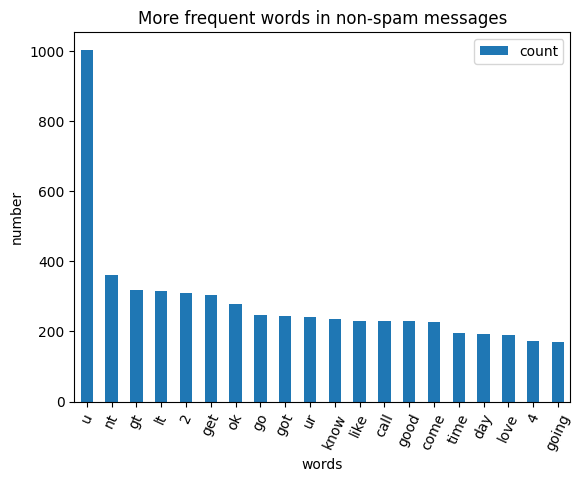

In [ ]:
# load the results as a pandas dataframe in order to plot
df_ham = pd.DataFrame(counter_Ham_20)

# Renaming the columns in this dataframe
df_ham = df_ham.rename(columns={0:"words in non-spam", 1:"count"}) # 0: 1st column jo ki words hai, 1: 2nd column jo ki count hai

# Plotting the data
df_ham.plot.bar(legend = True)
y_pos = np.arange(len(df_ham["words in non-spam"]))
plt.xticks(y_pos, df_ham["words in non-spam"], rotation= 65)
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

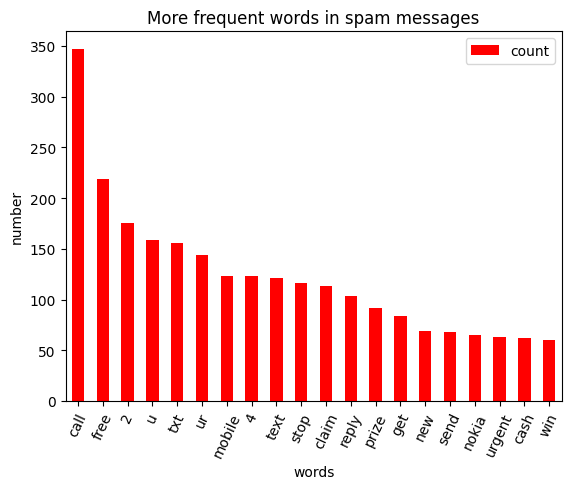

In [ ]:
# Similarly for the Spam texts

counter_spam_20 = Counter(" ".join(df[df['type']=='spam']["cleaned_message"]).split()).most_common(20)

df_spam = pd.DataFrame(counter_spam_20)
# Renaming the columns in this dataframe
df_spam = df_spam.rename(columns={0:"words in spam", 1:"count"}) # 0: 1st column jo ki words hai, 1: 2nd column jo ki count hoga
# Plotting the data
df_spam.plot.bar(legend = True, color= "red")
y_pos = np.arange(len(df_spam["words in spam"]))
plt.xticks(y_pos, df_spam["words in spam"], rotation= 65)
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

In [ ]:
df["type"]= df["type"].map({"spam":1, "ham":0})
# converting the categorical data into numerical data

In [ ]:
from sklearn.model_selection import train_test_split

df_X_train, df_X_test, y_train, y_test = train_test_split(df['cleaned_message'], df['type'], test_size=0.25, random_state=42)
print([np.shape(df_X_train), np.shape(df_X_test)])

[(4179,), (1393,)]


In [ ]:
# Since Naive Bayes is **not a distane based algorithm**, but rather an **information based algorithm**. Hence scaling does not help to converge it faster.

In [ ]:
from sklearn import feature_extraction, naive_bayes, metrics
# Count Vectorizer
f= feature_extraction.text.CountVectorizer()
X_train= f.fit_transform(df_X_train)
X_test= f.transform(df_X_test)

print(X_train.shape, X_test.shape)

(4179, 7615) (1393, 7615)


In [ ]:
# For Laplace smoothing constant
params= {
    "alpha": [0.001, 0.01, 0.1, 1, 5.2, 7, 10, 20, 50]
    }

In [ ]:
# Multinomial NB

from sklearn.model_selection import GridSearchCV

mnb = naive_bayes.MultinomialNB()
clf = GridSearchCV(mnb, params, scoring = "f1", cv=3) # cross_validation=3

clf.fit(X_train, y_train)

res = clf.cv_results_

for i in range(len(res["params"])):
  print(f"Parameters:{res['params'][i]} Mean_score: {res['mean_test_score'][i]} Rank: {res['rank_test_score'][i]}")

Parameters:{'alpha': 0.001} Mean_score: 0.8910846678837757 Rank: 5
Parameters:{'alpha': 0.01} Mean_score: 0.8937240112174837 Rank: 4
Parameters:{'alpha': 0.1} Mean_score: 0.8896934746467164 Rank: 6
Parameters:{'alpha': 1} Mean_score: 0.9022297472053865 Rank: 2
Parameters:{'alpha': 5.2} Mean_score: 0.9104721263548438 Rank: 1
Parameters:{'alpha': 7} Mean_score: 0.896239169232761 Rank: 3
Parameters:{'alpha': 10} Mean_score: 0.8603433402346446 Rank: 7
Parameters:{'alpha': 20} Mean_score: 0.7909961800777858 Rank: 8
Parameters:{'alpha': 50} Mean_score: 0.5975625183036403 Rank: 9


In [ ]:
# alpha=5.2 is the best value and as we increase value of the alpha after 7, score decreases i.e. overfitting inc
mnb = naive_bayes.MultinomialNB()
mnb.fit(X_train, y_train)

y_pred = mnb.predict(X_test)

print(metrics.f1_score(y_test,y_pred))

0.9214092140921409


In [ ]:
# The test value is almost equal to the train value with alpha= 5
# with unbalanced data and without scaling/ standrdization